## GPS Parser test


In [1]:
path = "../data/map.geo.admin.ch_GPX_20250522075309.gpx"

In [2]:
import gpxpy
from pyproj import Transformer

In [3]:
import geopandas as gpd
import pandas as pd

gdf_waypoints = gpd.read_file(path, layer="waypoints", driver="GPX")

gdf_routes = gpd.read_file(path, layer="routes", driver="GPX")

In [4]:
gdf_waypoints[["name", "geometry"]]

,name,geometry
0,Startpunkt,POINT (7.64171 47.53454)
1,Ende,POINT (7.71847 47.50206)
2,Hintere Burg,POINT (7.65754 47.52138)
3,Mittlere Burg,POINT (7.65502 47.51929)
4,Lecker Weinchen,POINT (7.66526 47.51354)
5,Schauenburg,POINT (7.67802 47.50065)


In [5]:
gdf_routes[["geometry"]]

,geometry
0,"LINESTRING (7.64171 47.53454, 7.64291 47.53396..."
1,"LINESTRING (7.65188 47.52106, 7.65199 47.5209,..."
2,"LINESTRING (7.7154 47.50267, 7.71546 47.50259,..."


MULTILINESTRING ((7.641710742787477 47.53454446080205, 7.642910871691948 47.53396101075464, 7.645252435715505 47.53335224206881, 7.647624992347028 47.53294833034201, 7.647748586101487 47.53317411425176, 7.648905216011105 47.53273412737372, 7.649203598429924 47.53246657443133, 7.649169191155308 47.53173502086567, 7.649286607221911 47.53153721851158, 7.649089108250109 47.531409409796495, 7.648968125925917 47.52999792593846, 7.648195178349839 47.52816967185314, 7.647843067651268 47.5277392824904, 7.647292434361079 47.52632405171279, 7.645189306598021 47.522800447986505, 7.64572010924461 47.5224740366459, 7.645951407597509 47.52188426481986, 7.6479761636840315 47.52196860113439, 7.648859120526183 47.5220989542324, 7.6500010656057595 47.52208808742866, 7.651283513546277 47.52151398185745, 7.651878622551316 47.52105547812883), (7.651878622551316 47.52105547812883, 7.651987677894958 47.52089725468919, 7.65231870834119 47.52092743418118, 7.652780001165105 47.52108052271184, 7.653078325994353 4

<Axes: >

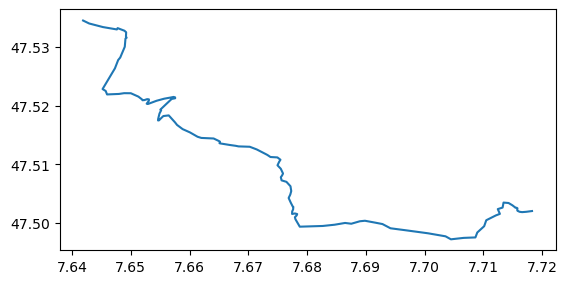

In [6]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge

mls     = MultiLineString(gdf_routes.geometry.tolist())
print(mls)
merged  = linemerge(mls)
print(merged)

gdf_merged = gpd.GeoDataFrame(
    {'geometry': [merged]}
)

gdf_merged.plot()

In [7]:
from shapely.geometry import LineString, Point, MultiPoint
from shapely.ops import split
import geopandas as gpd

points = gdf_waypoints.geometry.to_list()

projected = [merged.interpolate(merged.project(pt)) for pt in points]
print(projected)    

mp = MultiPoint(projected)

pieces = split(merged, mp)

segments = list(pieces.geoms)

gdf_points = gpd.GeoDataFrame(
    {'geometry': segments}
)
print(segments)
gdf_points



[<POINT (7.642 47.535)>, <POINT (7.718 47.502)>, <POINT (7.658 47.521)>, <POINT (7.655 47.519)>, <POINT (7.665 47.514)>, <POINT (7.678 47.501)>]
[<LINESTRING (7.642 47.535, 7.643 47.534, 7.645 47.533, 7.648 47.533, 7.648 4...>, <LINESTRING (7.658 47.521, 7.658 47.521, 7.657 47.521, 7.656 47.52, 7.655 47...>, <LINESTRING (7.655 47.519, 7.655 47.519, 7.655 47.519, 7.655 47.518, 7.655 4...>, <LINESTRING (7.665 47.514, 7.667 47.513, 7.668 47.513, 7.668 47.513, 7.67 47...>, <LINESTRING (7.678 47.501, 7.679 47.499, 7.683 47.499, 7.685 47.5, 7.686 47....>]


,geometry
0,"LINESTRING (7.64171 47.53454, 7.64291 47.53396..."
1,"LINESTRING (7.65754 47.52138, 7.65755 47.52123..."
2,"LINESTRING (7.65502 47.51929, 7.65517 47.51919..."
3,"LINESTRING (7.66526 47.51354, 7.66684 47.51328..."
4,"LINESTRING (7.67802 47.50065, 7.67876 47.49937..."


In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

gdf_points = gdf_points.set_crs(epsg=4326, allow_override=True)
gdf_lv95 = gdf_points.to_crs(epsg=2056)

gdf_lv95

,geometry
0,"LINESTRING (2615292.286 1264887.924, 2615382.8..."
1,"LINESTRING (2616488.117 1263427.786, 2616489.0..."
2,"LINESTRING (2616298.894 1263194.66, 2616310.18..."
3,"LINESTRING (2617072.551 1262557.063, 2617191.2..."
4,"LINESTRING (2618037.624 1261126.735, 2618093.9..."


In [9]:
def densify(linestring: LineString, interval: float = 20.0) -> LineString:
    """
    Fügt in einem LineString in gleichen Abständen von `interval` neue Punkte ein,
    behält dabei aber auch alle ursprünglichen Eckpunkte.
    """
    total_len = linestring.length

    # 1) Distanzen der originalen Eckpunkte entlang der Linie
    orig_dists = [linestring.project(Point(x, y)) for x, y in linestring.coords]

    # 2) Regelmäßige Distanzen 0, interval, 2*interval, ... bis < total_len
    regular_dists = list(np.arange(0, total_len, interval))

    # 3) Endpunkt sicher dazu
    regular_dists.append(total_len)

    # 4) Vereinigung und sortieren
    all_dists = sorted(set(orig_dists + regular_dists))

    # 5) An diesen Abständen interpolieren
    pts = [linestring.interpolate(d) for d in all_dists]

    # 6) Als neuen LineString zurückgeben
    return LineString([(p.x, p.y) for p in pts])


                                            geometry
0  LINESTRING (2615292.286 1264887.924, 2615373.6...
1  LINESTRING (2616488.117 1263427.786, 2616489.0...
2  LINESTRING (2616298.894 1263194.66, 2616310.18...
3  LINESTRING (2617072.551 1262557.063, 2617169.8...
4  LINESTRING (2618037.624 1261126.735, 2618074.5...


<Axes: >

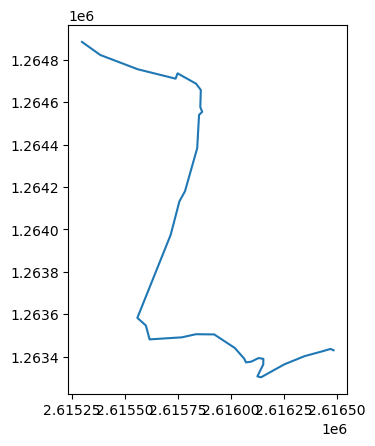

In [10]:
gdf_lv95['geometry'] = gdf_lv95.geometry.apply(lambda ln: densify(ln, interval=100.0))

# 3. (Optional) CRS anpassen, falls es sich geändert hat
# gdf.set_crs(epsg=2056, inplace=True)

print(gdf_lv95)

gdf_lv95.head(1).plot()

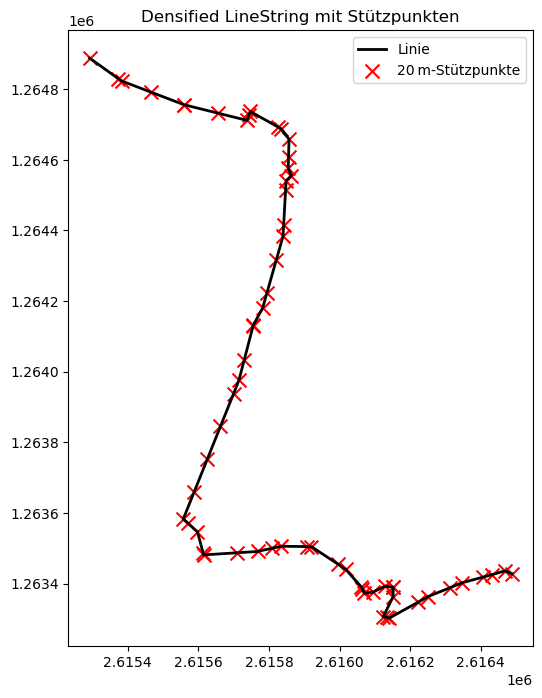

In [11]:
import matplotlib.pyplot as plt

# 1) Deinen (bereits densified) LineString holen
dense_line0 = gdf_lv95.geometry.iloc[0]

# 2) Koordinaten extrahieren
# Variante a: mit coords
coords = list(dense_line0.coords)     # [(x1,y1), (x2,y2), ...]
x_pts, y_pts = zip(*coords)

# Variante b: mit .xy
# x_pts, y_pts = dense_line0.xy

# 3) Plotten
fig, ax = plt.subplots(figsize=(6,8))
#    erst die Linie
x_line, y_line = dense_line0.xy
ax.plot(x_line, y_line, '-', lw=2, color='black', label='Linie')
#    dann die Punkte
ax.scatter(x_pts, y_pts, s=100, c='red', marker='x', label='20 m-Stützpunkte')

ax.set_aspect('equal')
ax.set_title("Densified LineString mit Stützpunkten")
ax.legend()
plt.show()


In [12]:
import requests
import time
import geopandas as gpd
from shapely.geometry import LineString

# 1. Konfiguration: Basis-URL der Swisstopo Height-API
HEIGHT_URL = "https://api3.geo.admin.ch/rest/services/height"


def get_height(easting: float, northing: float, max_retries: int = 3) -> float:
    """
    Fragt die Höhe für einen Punkt (in LV95) bei der Swisstopo-API ab
    und gibt sie als float zurück.
    """
    params = {"easting": easting, "northing": northing}
    for attempt in range(max_retries):
        r = requests.get(HEIGHT_URL, params=params, timeout=5)
        if r.status_code == 200:
            return r.json()["height"]
    r.raise_for_status()


def to_3d_linestring(line2d: LineString) -> LineString:
    """
    Nimmt einen 2D-LineString (in LV95) und erzeugt daraus einen 3D-LineString,
    indem für jeden originalen Stützpunkt (Koordinate) die Höhe
    aus der Swisstopo-API abgefragt wird.
    """
    # 1) Original-Koordinaten des Linestrings
    coords2d = list(line2d.coords)

    # 2) Für jede Koordinate (x, y) die Höhe abfragen und 3D-Koordinate erstellen
    coords3d = []
    for x, y in coords2d:
        z = get_height(x, y)
        coords3d.append((x, y, z))

    # 3) Neuer 3D-LineString
    return LineString(coords3d)


In [16]:
from tqdm.notebook import tqdm
# ------------------------------
# Anwendung auf das GeoDataFrame mit Fortschrittsbalken

# Annahme: gdf_lv95 hat bereits 2D-Linestrings in LV95 (EPSG:2056)
# Beispiel: gdf_lv95 = gdf.to_crs(epsg=2056)

gdf_3d = gdf_lv95.copy()
# Die folgende Schleife zeigt einen Fortschrittsbalken in Jupyter Notebook
geoms = []
pbar = tqdm(gdf_lv95.geometry, desc="Linestrings verarbeiten", unit="stück")
for line in pbar:
    length = line.length  # Länge in Meter (LV95)
    pbar.set_postfix_str(f"Länge={length:.1f}m")
    geoms.append(to_3d_linestring(line))

gdf_3d["geometry"] = geoms
# CRS inkl. Z behalten
gdf_3d.set_crs(epsg=2056, inplace=True)

# Ergebnis prüfen
print(gdf_3d.head())


Linestrings verarbeiten:   0%|          | 0/5 [00:00<?, ?stück/s]

                                            geometry
0  LINESTRING Z (2615292.286 1264887.924 279.7, 2...
1  LINESTRING Z (2616488.117 1263427.786 431.5, 2...
2  LINESTRING Z (2616298.894 1263194.66 476.4, 26...
3  LINESTRING Z (2617072.551 1262557.063 411, 261...
4  LINESTRING Z (2618037.624 1261126.735 568.2, 2...


In [15]:
# --- Zusätzliche Auswertungen: Länge und Anzahl Stützpunkte pro LineString ---
# Länge in Metern (CRS LV95 basiert auf Meter-Einheiten)
gdf_3d['laenge_m'] = gdf_3d.geometry.length
# Anzahl Stützpunkte = Anzahl der Koordinaten im LineString
gdf_3d['anzahl_stuetzpunkte'] = gdf_3d.geometry.apply(lambda ls: len(ls.coords))

# Ausgabe der berechneten Spalten
print(gdf_3d[['laenge_m', 'anzahl_stuetzpunkte']])

      laenge_m  anzahl_stuetzpunkte
0  2984.728380                   63
1   313.321154                    8
2  1308.858274                   34
3  2164.939274                   55
4  3807.934134                   76


In [17]:
path_v2 = "../data/7-gipfel-tour-flumserberg.gpx"

In [23]:

gdf_waypoints = gpd.read_file(path_v2, layer="waypoints", driver="GPX")

gdf_routes = gpd.read_file(path_v2, layer="tracks", driver="GPX")

In [19]:
gdf_waypoints[["name", "geometry"]]

,name,geometry
0,Startpunkt,POINT (9.25339 47.06976)
1,Ziel,POINT (9.28076 47.09286)


In [26]:
gdf_routes[["geometry"]]

,geometry
0,"MULTILINESTRING ((9.25339 47.06976, 9.25373 47..."


In [28]:
import gpxpy
import gpxpy.gpx
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)

points_lv95 = []
with open(path_v2, 'r', encoding='utf-8') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lon, lat, elev = point.longitude, point.latitude, point.elevation or 0.0
                # Transformation in LV95
                e, n = transformer.transform(lon, lat)
                points_lv95.append((e, n, elev))

print(points_lv95[:5])  # Ausgabe der ersten 5 Punkte


[(2737832.7314970535, 1214786.6889505791, 1974.2), (2737858.9103194005, 1214771.7263362168, 1965.5), (2737856.8636531713, 1214761.6706297107, 1964.4), (2737837.003289095, 1214733.410043228, 1961.3), (2737823.36012662, 1214731.9822731272, 1964.2)]


In [32]:
import xml.etree.ElementTree as ET

def detect_gpx_source(filepath: str) -> str:
    """
    Liest eine GPX-Datei ein und gibt zurück,
    ob sie mit der Swisstopo-App oder via Web (OpenLayers) erstellt wurde.

    Rückgabe:
      - 'app' für Swisstopo App
      - 'web' für Web-Export (OpenLayers)
      - 'unknown' falls weder eindeutig noch lesbar
    """
    # Namespace für schemaLocation
    XSI = "http://www.w3.org/2001/XMLSchema-instance"

    try:
        tree = ET.parse(filepath)
        root = tree.getroot()

        # Ermitteln des 'creator'-Attributs
        creator = root.attrib.get("creator", "").lower()

        # Ermitteln der schemaLocation (XML Schema Instance)
        schema_loc = root.attrib.get(f"{{{XSI}}}schemaLocation", "").lower()

        # Prüfen auf typische Swisstopo-App-Kennzeichen
        if "swisstopo app" in creator or "swisstopoextensions.xsd" in schema_loc:
            return "app"

        # Prüfen auf typische Web-Kennzeichen
        if "openlayers" in creator:
            return "web"

        return "unknown"
    except ET.ParseError:
        raise ValueError(f"Datei '{filepath}' ist kein gültiges XML/GPX.")
    except FileNotFoundError:
        raise ValueError(f"Datei '{filepath}' nicht gefunden.")


detect_gpx_source(path_v2)
detect_gpx_source(path)
detect_gpx_source("../data/11-05_TrackGPS.gpx")

'unknown'